<a href="https://colab.research.google.com/github/deep-diver/Continuous-Adaptation-for-Machine-Learning-System-to-Data-Changes/blob/main/notebooks/03_Batch_Prediction_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Batch Prediction Pipeline

The main purpose of this notebook is to build KFP pipeline doing the following steps
1. Create an batch request input file (file list format) based on the files uploaded to a GCS bucket
2. Run Batch Prediction on the trained model obtained from [02_TFX_Training_Pipeline.ipynb](https://github.com/deep-diver/Continuous-Adaptation-for-Machine-Learning-System-to-Data-Changes/blob/main/notebooks/02_TFX_Training_Pipeline.ipynb)
3. Measure the batch prediction model performance in terms of accuracy
4. If model performance < threshold
  - Copy the testing images to the original(previous) dataset
  - Trigger the TFX training pipeline with original data + newly added data

The functional test for batch prediction is shown in a separate notebook, [98_Batch_Prediction_Test.ipynb](https://github.com/deep-diver/Continuous-Adaptation-for-Machine-Learning-System-to-Data-Changes/blob/main/notebooks/98_Batch_Prediction_Test.ipynb).

## Setup

In [ ]:
!pip install fastdot
!pip install tfx==1.2.0
!pip install kfp==1.6.1
!pip install -q --upgrade google-cloud-aiplatform
!pip install -q --upgrade google-cloud-storage

In [ ]:
!gcloud init

In [24]:
from google.colab import auth
auth.authenticate_user()

## Custom TFX Components

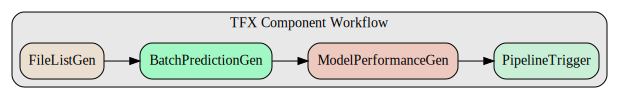

In [3]:
#@title
from fastdot.core import *

tfx_components = ['FileListGen', 'BatchPredictionGen', 'ModelPerformanceGen', 'PipelineTrigger']
block = 'TFX Component Workflow'

g = graph_items(seq_cluster(tfx_components, block))
g

### **FileListGen Component**

- `FileListGen` will produce a `file list` file that `BatchPredictionGen` will refer to perform batch prediction on Vertex AI
- `file list` format can be found [here](https://cloud.google.com/vertex-ai/docs/predictions/batch-predictions)

**Spec**
- input
  - GCS path where the raw files are
  - GCS path where the `file list` file will be 
- output
  - GCS path where the `file list` file is

#### Testing

In [27]:
GOOGLE_CLOUD_PROJECT = 'central-hangar-321813'    #@param {type:"string"}
GOOGLE_CLOUD_REGION = 'us-central1'             #@param {type:"string"}

MODEL_NAME = 'resnet_cifar_latest' #@param {type:"string"}

TEST_FILENAME = 'test-images.txt' #@param {type:"string"}
TEST_GCS_BUCKET = 'batch-prediction-collection' #@param {type:"string"}
TEST_GCS_PREFIX = '' #@param {type: "string"}

In [28]:
from google.cloud import storage

In [33]:
client = storage.Client(project=GOOGLE_CLOUD_PROJECT)
bucket = client.get_bucket(TEST_GCS_BUCKET)
blobs = bucket.list_blobs(prefix=TEST_GCS_PREFIX)

f = open(TEST_FILENAME, "w")

for blob in blobs:
  if blob.name.split('.')[-1] == "jpg":
    if TEST_GCS_PREFIX != '':
      TEST_GCS_PREFIX = f'/{TEST_GCS_PREFIX}'
    line = f'{TEST_GCS_BUCKET}{TEST_GCS_PREFIX}/{blob.name}\n'

    f.write(line)

f.close()

In [36]:
!cat {TEST_FILENAME}

batch-prediction-collection/airplane_0000.jpg
batch-prediction-collection/automobile_0000.jpg
batch-prediction-collection/bird_0000.jpg
batch-prediction-collection/cat_0000.jpg
batch-prediction-collection/deer_0000.jpg
batch-prediction-collection/dog_0000.jpg
batch-prediction-collection/frog_0000.jpg
batch-prediction-collection/horse_0000.jpg
batch-prediction-collection/ship_0000.jpg
batch-prediction-collection/truck_0000.jpg


In [40]:
blob = bucket.blob(f'test/{TEST_FILENAME}')

In [41]:
blob.upload_from_filename(TEST_FILENAME)

#### Module

In [34]:
_file_list_gen_module_file = 'file_list_gen.py'

In [51]:
%%writefile {_file_list_gen_module_file}

from tfx import v1 as tfx
from tfx.dsl.component.experimental.decorators import component
from tfx.dsl.component.experimental.annotations import Parameter
from google.cloud import storage
from absl import logging

@component
def FileListGen(
    project: Parameter[str],
    gcs_source_bucket: Parameter[str],
    gcs_source_prefix: Parameter[str] = '',
    output_filename: Parameter[str] = 'test-images.txt'
) -> tfx.dsl.components.OutputDict(outpath=str):
  logging.info('FileListGen started')

  client = storage.Client(project=project)
  bucket = client.get_bucket(gcs_source_bucket)
  blobs = bucket.list_blobs(prefix=gcs_source_prefix)
  logging.info('Successfully retrieve the file(jpg) list from GCS path')

  f = open(output_filename, 'w')
  for blob in blobs:
    if blob.name.split('.')[-1] == 'jpg':
      prefix = ''
      if gcs_source_prefix != '':
        prefix = f'/{gcs_source_prefix}'
      line = f'{gcs_source_bucket}{prefix}/{blob.name}\n'
      f.write(line)
  f.close()
  logging.info(f'Successfully created the file list file({output_filename}) in local storage')

  prefix = ''
  if gcs_source_prefix != '':
    prefix = f'{gcs_source_prefix}/'
  blob = bucket.blob(f'{prefix}{output_filename}')
  blob.upload_from_filename(output_filename)
  logging.info(f'Successfully uploaded the file list ({prefix}{output_filename})')

  return {
      'outpath': gcs_source_bucket + '/' + prefix + output_filename,
  }

Overwriting file_list_gen.py


### BatchPredictionGen Component
- Behaviour of `BatchPredictionGen` is similar to TFX standard component `BulkInferrer`.
- The only difference is we don't need `Model` artifact from `Trainer` but just `model ID` that can be found in `Vertex AI Model` registry.
- Predicted results will be fed into the `PerformanceEvaluator` component.

**Spec**
- input
  - GCS path where the TFRecord file is
  - model id from Vertex AI Model
- output
  - predictions

### **PerformanceEvaluator Component**
- Calculate any performance metrics 
- Outputs if the model performance is above or below the given threshold

**Spec**
- input
  - predictions
  - threshold
- output
  - `True` or `False` by the threshold

### PipelineTrigger Component
- Trigger the training pipeline based on the `True` or `False` value by the threshold

**Spec**
- input
  - `True` or `False` by threshold
  - pipeline name to be triggered
  - GCS path where the pipeline spec is 
  - GCP project ID
  - GCP region
- output
  - None

# Pipeline

In [52]:
GOOGLE_CLOUD_PROJECT = 'central-hangar-321813'        #@param {type:"string"}
GOOGLE_CLOUD_REGION = 'us-central1'                   #@param {type:"string"}
GCS_BUCKET_NAME = 'cifar10-experimental-batch-csp'    #@param {type:"string"}

TEST_FILENAME = 'test-images.txt' #@param {type:"string"}
TEST_GCS_BUCKET = 'batch-prediction-collection' #@param {type:"string"}
TEST_GCS_PREFIX = '' #@param {type: "string"}

if not (GOOGLE_CLOUD_PROJECT and GOOGLE_CLOUD_REGION and GCS_BUCKET_NAME):
    from absl import logging
    logging.error('Please set all required parameters.')

In [53]:
PIPELINE_NAME = 'continuous-adaptation-for-data-changes-batch'

# Path to various pipeline artifact.
PIPELINE_ROOT = 'gs://{}/pipeline_root/{}'.format(
    GCS_BUCKET_NAME, PIPELINE_NAME)

print('PIPELINE_ROOT: {}'.format(PIPELINE_ROOT))

PIPELINE_ROOT: gs://cifar10-experimental-batch-csp/pipeline_root/continuous-adaptation-for-data-changes-batch


In [54]:
!mkdir -p ./custom_components
!touch ./custom_components/__init__.py
!cp -r {_file_list_gen_module_file} custom_components

In [55]:
DISPLAY_NAME = "batch-prediction-pipeline"
VERSION = "tfx-1-2-0"
TFX_IMAGE_URI = f"gcr.io/{GOOGLE_CLOUD_PROJECT}/{DISPLAY_NAME}:{VERSION}"
print(f"URI of the custom image: {TFX_IMAGE_URI}")

URI of the custom image: gcr.io/central-hangar-321813/batch-prediction-pipeline:tfx-1-2-0


In [56]:
%%writefile Dockerfile

FROM gcr.io/tfx-oss-public/tfx:1.2.0
RUN mkdir -p custom_components
COPY custom_components/* ./custom_components/
RUN pip install --upgrade google-cloud-aiplatform google-cloud-storage

Overwriting Dockerfile


In [ ]:
!gcloud builds submit --tag $TFX_IMAGE_URI . --timeout=15m --machine-type=e2-highcpu-8

In [58]:
import tfx
from tfx.orchestration.pipeline import Pipeline
from custom_components.file_list_gen import FileListGen

def _create_pipeline(
    pipeline_name: str,
    pipeline_root: str,
    data_gcs_bucket: str,
    data_gcs_prefix: str,
    project_id: str,
    region: str,
) -> Pipeline :
  filelist_gen = FileListGen(
      project = project_id, 
      gcs_source_bucket = data_gcs_bucket,
      gcs_source_prefix = data_gcs_prefix,
  )

  components = [
    filelist_gen,
  ]

  return Pipeline(
      pipeline_name=pipeline_name, 
      pipeline_root=pipeline_root,
      components=components
  )

In [59]:
import os
import tfx
from tfx.orchestration.kubeflow.v2.kubeflow_v2_dag_runner import KubeflowV2DagRunner
from tfx.orchestration.kubeflow.v2.kubeflow_v2_dag_runner import KubeflowV2DagRunnerConfig

PIPELINE_DEFINITION_FILE = PIPELINE_NAME + '_pipeline.json'

# Important: We need to pass the custom Docker image URI to the
# `KubeflowV2DagRunnerConfig` to take effect.
runner = KubeflowV2DagRunner(
    config=KubeflowV2DagRunnerConfig(default_image=TFX_IMAGE_URI),
    output_filename=PIPELINE_DEFINITION_FILE)

_ = runner.run(
    _create_pipeline(
        pipeline_name=PIPELINE_NAME,
        pipeline_root=PIPELINE_ROOT,
        data_gcs_bucket=TEST_GCS_BUCKET,
        data_gcs_prefix=TEST_GCS_PREFIX,
        project_id=GOOGLE_CLOUD_PROJECT,
        region=GOOGLE_CLOUD_REGION
    )
)

In [60]:
from kfp.v2.google import client

pipelines_client = client.AIPlatformClient(
    project_id=GOOGLE_CLOUD_PROJECT,
    region=GOOGLE_CLOUD_REGION,
)

_ = pipelines_client.create_run_from_job_spec(PIPELINE_DEFINITION_FILE, enable_caching=True)

![img](https://i.ibb.co/521KpYm/Screen-Shot-2021-09-19-at-12-33-18-AM.png)